## Analiza sygnału EKG
Procedura analizy sygnału EKG: celem jest określenie parametrów tętna (Heart Rate HR), zmięnność tętna (Heart Rate Variability HRV) oraz wydatku energetycznego (energy expedinture)

#### 1. Pomiar sygnału EKG 
 - zmierz sygnał EKG przez około 10 minut w pozycji "zrelaksowanej": EKG spoczynkowy;
 - zmierz sygnał EKG przez około 10 minut, przez pierwsze 3 minuty pozostań zrelakoswoany, podejmij wysiłek fizyczny przez kolejne około 3 minuty (rower, rower stacjonarny?), pozostań zrelaksowany przez pozostały czas 

#### 2. Import bibliotek

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as f
import pandas as pd
import scipy.signal
import ekg_analyze_lib as ekglib

#### 3. Wczytanie danych pomiarowych z pliku

In [50]:
kolumny = ['ekg', 't']
rest_ekg = pd.read_csv('resting.txt', 
        names = kolumny, sep='\t', skiprows=5000, skipfooter=5000, engine='python')

In [52]:
print(rest_ekg.ekg)

0         317
1         317
2         317
3         318
4         318
         ... 
328161    301
328162    302
328163    304
328164    306
328165    310
Name: ekg, Length: 328166, dtype: int64


In [54]:
print(rest_ekg.t)

0         327319
1         327320
2         327321
3         327322
4         327323
           ...  
328161    656964
328162    656965
328163    656966
328164    656967
328165    656968
Name: t, Length: 328166, dtype: int64


In [56]:
#częstotliwość próbkowania
fs = 1000   

#zmiana ms na s
rest_ekg.t = (rest_ekg.t)/1000

In [58]:
print(rest_ekg.t)

0         327.319
1         327.320
2         327.321
3         327.322
4         327.323
           ...   
328161    656.964
328162    656.965
328163    656.966
328164    656.967
328165    656.968
Name: t, Length: 328166, dtype: float64


#### 4. Wizualizacja wyników pomiarów

Text(0.5, 0, 't / s')

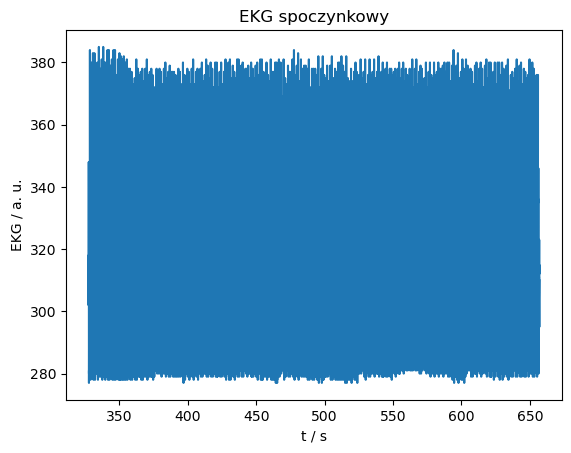

In [61]:
plt.plot(rest_ekg.t, rest_ekg.ekg)
plt.title('EKG spoczynkowy')
plt.ylabel('EKG / a. u.')
plt.xlabel('t / s')

(453.0, 458.0)

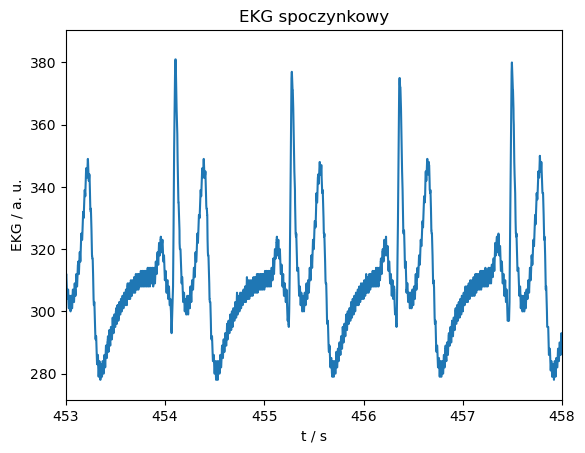

In [63]:
#zawężenie osi czasu
plt.plot(rest_ekg.t, rest_ekg.ekg)
plt.title('EKG spoczynkowy')
plt.ylabel('EKG / a. u.')
plt.xlabel('t / s')
plt.xlim(453,458)

#### 5. Widmo sygnału

In [66]:
F = f.fft(rest_ekg.ekg)
N = len(rest_ekg.ekg)
freq = f.fftfreq(N, 1.0/fs) #wyznaczenie częstotliwoci próbek fft
mask = np.where(freq>=0)
F[0]=0  #wyzerowanie składowej stałej

In [68]:
print(F)

[    0.           +0.j         -4050.31184814+2736.63338717j
 -4139.88524865 +439.47101239j ... -3798.56432334 +116.8857279j
 -4139.88524865 -439.47101239j -4050.31184814-2736.63338717j]


Text(0.5, 0, 'f / Hz')

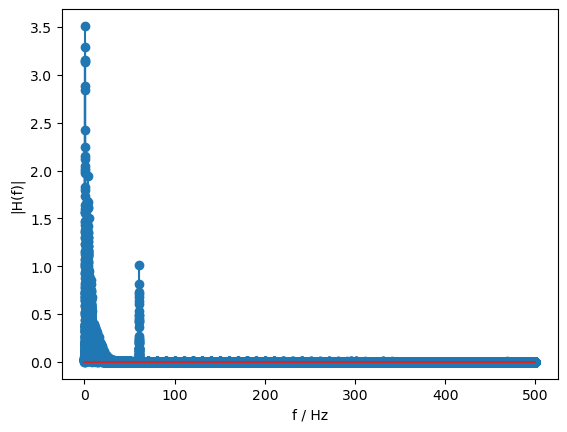

In [70]:
#charakterystyka amplitudowa
plt.stem(freq[mask], 2*np.abs(F[mask])/N)
plt.ylabel('|H(f)|')
plt.xlabel('f / Hz')

(0.0, 100.0)

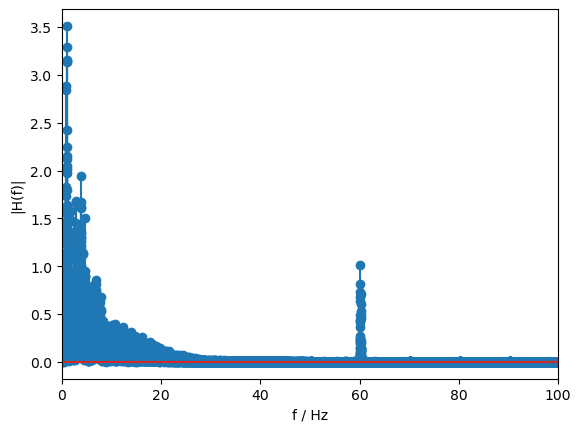

In [71]:
#skala logarytmiczna, zawężenie widma
plt.stem(freq[mask], 2*np.abs(F[mask])/N)
plt.ylabel('|H(f)|')
plt.xlabel('f / Hz')
#plt.yscale('log')
plt.xlim(0,100)

#### 6. Filtracja sygnału (opcjonalnie)

(400.0, 405.0)

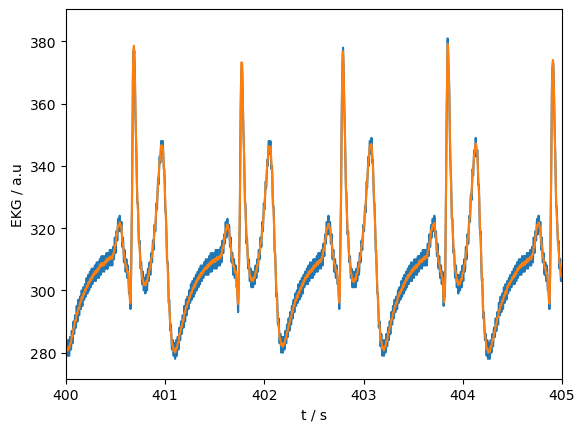

In [75]:
#filtracja sygnału
fc = 50 #częstotliwoć odcięcia filtru
Wn = 2*fc/fs
b, a = scipy.signal.butter(4, Wn, 'low', analog=False)
ekg_filt = scipy.signal.filtfilt(b, a, rest_ekg.ekg)
plt.plot(rest_ekg.t, rest_ekg.ekg, rest_ekg.t, ekg_filt)
plt.xlabel('t / s')
plt.ylabel('EKG / a.u')
plt.xlim(400,405)
#plt.ylim(-2,3)

#### 7. Określenie pozycji pików R 

(365.0, 375.0)

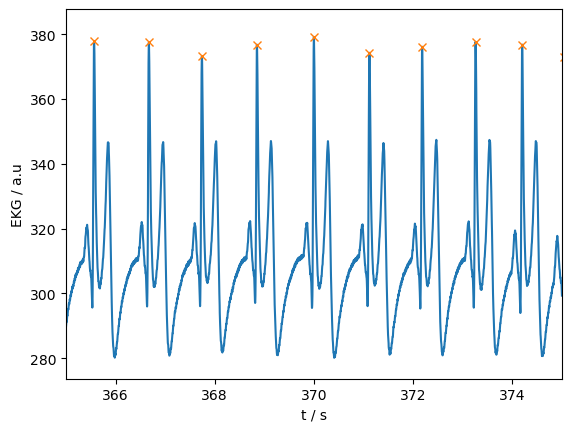

In [78]:
# użycie funkcji findpeaks()
pikiR,_ = scipy.signal.find_peaks(ekg_filt, height=360)
plt.plot(rest_ekg.t, ekg_filt)
plt.plot(rest_ekg.t[pikiR], ekg_filt[pikiR], 'x')
plt.xlabel('t / s')
plt.ylabel('EKG / a.u')
plt.xlim(365,375)

#### 8. Określenie pozycji pików R z użyciem biblioteki ekg_analyze_lib

In [81]:
#poszukiwanie maksimów w pochodnej ekg
d_ekg, peaks_d_ekg = ekglib.decg_peaks(ekg_filt, rest_ekg.t) 

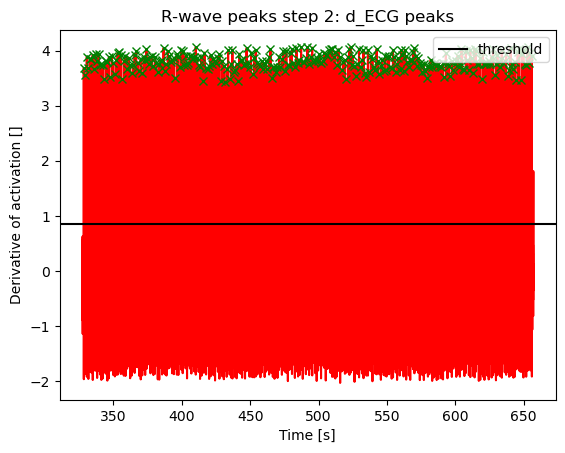

In [83]:
#pozycje pików R w pochodnej
R_peaks_d_ekg = ekglib.d_ecg_peaks(d_ekg, peaks_d_ekg, rest_ekg.t, 0.4, 0.45)

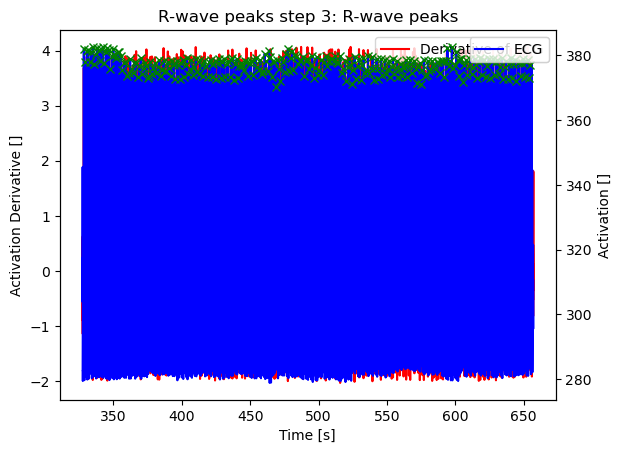

In [85]:
#pozycja pików R
R_peaks = ekglib.Rwave_peaks(ekg_filt, d_ekg, R_peaks_d_ekg, rest_ekg.t)

#### 9. Obliczenie HR oraz HRV

In [88]:
# obliczenie interwałów
intervals = np.diff(R_peaks)

In [90]:
print(intervals)

[1.099 1.1   1.121 1.079 1.061 1.078 1.057 1.025 1.106 1.077 1.008 1.02
 1.053 1.052 1.106 1.163 1.15  1.091 1.026 1.109 1.116 1.015 1.049 1.064
 1.188 1.074 1.155 1.219 1.169 1.107 1.16  1.132 1.081 1.062 1.104 1.068
 1.11  1.149 1.119 1.064 1.077 0.939 0.851 0.883 1.183 1.106 1.04  1.092
 1.087 1.028 1.068 1.078 1.037 1.084 1.073 0.999 1.046 1.07  1.035 1.097
 1.167 1.117 1.079 1.11  1.039 1.035 1.082 1.087 1.021 1.057 1.059 1.022
 1.095 1.089 1.038 1.083 1.082 1.006 1.041 1.099 1.053 1.114 1.158 1.105
 1.113 1.116 1.06  1.033 1.114 1.062 1.047 1.093 1.071 1.066 1.087 1.053
 1.019 1.092 1.059 1.017 1.05  1.009 0.998 1.035 1.033 0.964 0.994 1.062
 1.041 1.064 1.162 1.087 1.058 1.13  1.121 1.132 1.169 1.174 1.086 1.133
 1.112 0.996 0.996 1.056 1.042 1.161 1.005 0.827 0.88  1.237 1.09  1.097
 1.124 1.039 1.045 1.138 1.058 1.065 1.108 1.046 0.982 0.987 1.081 1.011
 1.192 1.142 1.09  1.172 1.178 1.158 1.114 1.19  1.191 1.111 1.157 1.13
 1.04  1.087 1.049 1.016 1.128 1.158 1.101 1.192 1.19

In [92]:
#obliczenie pulsu
HR = (1/intervals)*60

In [94]:
print(HR)

[54.59508644 54.54545455 53.52363961 55.60704356 56.55042413 55.65862709
 56.76442763 58.53658537 54.24954792 55.71030641 59.52380952 58.82352941
 56.98005698 57.03422053 54.24954792 51.59071367 52.17391304 54.99541705
 58.47953216 54.10279531 53.76344086 59.11330049 57.19733079 56.39097744
 50.50505051 55.86592179 51.94805195 49.22067268 51.32591959 54.20054201
 51.72413793 53.00353357 55.50416281 56.49717514 54.34782609 56.17977528
 54.05405405 52.21932115 53.61930295 56.39097744 55.71030641 63.89776358
 70.5052879  67.95016988 50.71851226 54.24954792 57.69230769 54.94505495
 55.19779209 58.36575875 56.17977528 55.65862709 57.85920926 55.35055351
 55.91798695 60.06006006 57.36137667 56.07476636 57.97101449 54.6946217
 51.41388175 53.71530886 55.60704356 54.05405405 57.74783446 57.97101449
 55.45286506 55.19779209 58.76591577 56.76442763 56.6572238  58.70841487
 54.79452055 55.09641873 57.80346821 55.40166205 55.45286506 59.64214712
 57.63688761 54.59508644 56.98005698 53.85996409 51.

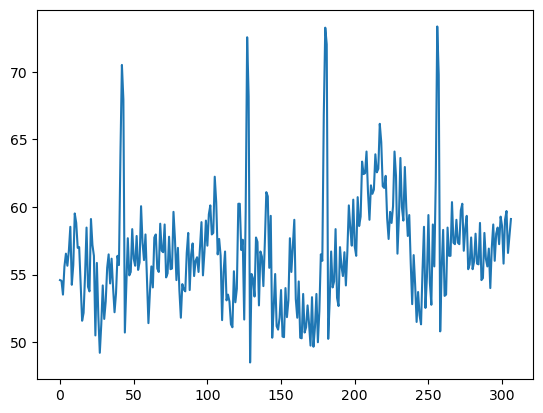

In [96]:
plt.plot(HR)

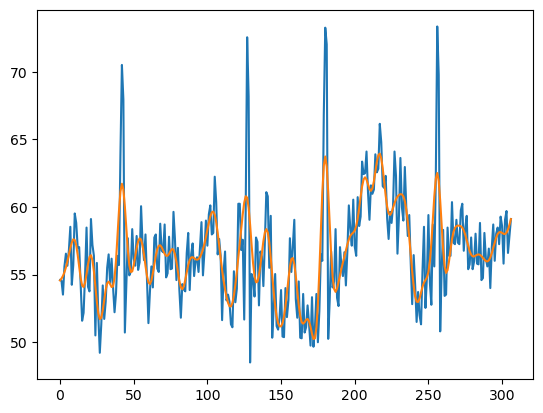

In [98]:
#filtracja (opcjonalnie) HR
Wn = 0.2 #dobierz eksperymentalnie
b2, a2 = scipy.signal.butter(4, Wn, btype='lowpass') 
HR_filt = scipy.signal.filtfilt(b2, a2, HR)
plt.plot(HR)
plt.plot(HR_filt)

In [100]:
#obliczenie HRV - odchylenie standardowe dla HR (niefiltrowane)
HRV = np.std(HR)
print(HRV)

4.035466366905536


In [102]:
#Szacowany wydatek energetyczny na podstawie HR (wg Keytel et al.)
ee_kj_min = -59.3954 + 0.45 * HR
ee_kcal_min = ee_kj_min / 4.184

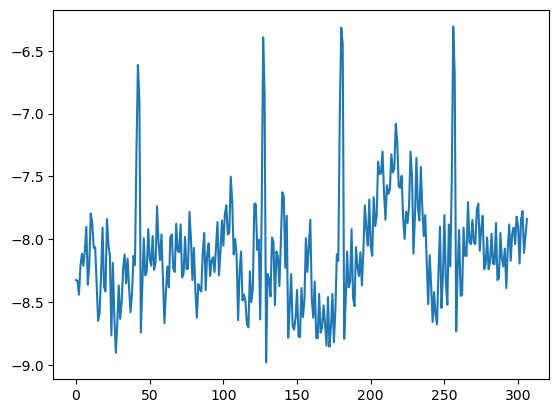

In [104]:
plt.plot(ee_kcal_min)